In [6]:
from scipy import stats
%matplotlib inline
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import matplotlib.cm as cm
from Funciones_auxiliares import Mat_to_dataframe,see_teams,get_cluster_indexs,plot_branch,plot_teams,find_mix
from scipy import cluster
from scipy.spatial.distance import mahalanobis

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import scipy as sp
import math

### Importamos la data

In [7]:
plt.close('all')
plt.clf()
plt.close()

data = pd.read_pickle('Datos/PCCIBNMZc')
data['Mean'] = data.Bulk.apply(lambda row: np.mean(row,axis = 0))
data['Mean'] = (data['Mean'] - data.Mean.apply(lambda row:np.mean(row)))/data.Mean.apply(lambda row:np.std(row))
del data['Bulk']
Number_seesions = len(data.PatientExperiment.unique())
print('There are',Number_seesions,' sessions in the data')

There are 60  sessions in the data


## Separamos en Test y Train por sessiones

## No tengo que entrenar nada, asumimos que el template matching para train es perfecto

Distancia Mahalanobis, necesitamos computar la matriz de covarianza. Dado que asumimos que hay 64 variables la matriz de covarianza.

In [8]:
def Train_test_noise(data):
    Sessions_list = data.PatientExperiment.unique()
    Train_list = np.random.choice(Sessions_list, size=int(len(Sessions_list)/2),replace = False)
    Train = data[data.PatientExperiment.isin(Train_list)]
    Test = data[~data.PatientExperiment.isin(Train_list)]
    Train = Train.reset_index().rename(columns = {'index':'old_index'})
    Test = Test.reset_index().rename(columns = {'index':'old_index'})
    
    df_train = Train.copy()
    df_test = Test.copy()
    
    Noise = df_train[df_train.bNoise == 1]
    Neuron = df_train[df_train.bNoise == 0]
    MU = df_train[df_train.bNoise == 2]

    df_train = pd.concat([Neuron,MU,Noise], ignore_index= True, sort = False)

    Noise = df_test[df_test.bNoise == 1]
    Neuron = df_test[df_test.bNoise == 0]
    MU = df_test[df_test.bNoise == 2]

    df_test = pd.concat([Neuron,MU,Noise], ignore_index= True, sort = False)

    Cov = np.array(df_train.Mean.to_list()).T
    Cov = np.cov(Cov)
    
    return df_train,df_test,Cov

df_train,df_test,Cov = Train_test_noise(data)
print(len(df_train),len(df_test))
print(len(df_train.PatientExperiment.unique()),len(df_test.PatientExperiment.unique()))

671 899
30 30




## Testeamos

In [9]:
from scipy.spatial.distance import squareform, pdist

def compute_dist(df_test,df_train):
    df = pd.concat([df_train,df_test],ignore_index=True,sort = True)
    r = len(df_train)
    Dist = pd.DataFrame(squareform(pdist(np.array(df.loc[:, 'Mean'].to_list()),metric = 'mahalanobis',VI = Cov)),columns=df.index,index=df.index).values
    Dist = Dist[r:,:r]
    return Dist

Dist = compute_dist(df_test,df_train)

Vemos la matriz de distancia, la linea negra separa neuron-noise

([<matplotlib.axis.XTick at 0x7f59cc875790>,
 <a list of 3 Text xticklabel objects>)

([<matplotlib.axis.YTick at 0x7f59cc8fe890>,
 <a list of 3 Text yticklabel objects>)

Text(0.5, 1, 'Mahalanobis distance')

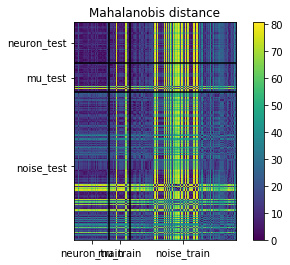

In [10]:
fig,ax = plt.subplots()
fig.canvas.draw()

t2 = df_test[df_test.bNoise == 1].index[0]
m2 = df_test[df_test.bNoise == 2].index[0]
t = df_train[df_train.bNoise == 1].index[0]
m = df_train[df_train.bNoise == 2].index[0]

xlabels = ['neuron_train','mu_train','noise_train']
ylabels = ['neuron_test','mu_test','noise_test']

plt.xticks([m/2,(t+m)/2,(len(Dist[0])+t)/2],xlabels)
plt.yticks([m2/2,(t2+m2)/2,(len(Dist)+t2)/2],ylabels)

plt.title('Mahalanobis distance')

plt.hlines(t2,0,len(Dist[0])-1)
plt.hlines(m2,0,len(Dist[0])-1)

plt.vlines(t,0,len(Dist)-1)
plt.vlines(m,0,len(Dist)-1)

plt.imshow(Dist)
plt.colorbar()

Ahora tenemos una matriz de distancias. Cada fila representa la distancia de un template test a cada uno de los templates de train. Computamos el minimo, y nos fijamos si es neuron o noise, entonces asignamos ese valor.

In [6]:
number_votes = 1
Minn = [np.argsort(i)[:number_votes][0] for i in Dist[:]]
Minn = np.array(Minn)


In [7]:
def create_label(lista,t,m):
    label = np.zeros(len(lista),dtype = int)
    noises_index = np.where(lista >= t)[0]
    mu_index = np.where((lista<t) & (lista>=m))[0]
    for i in noises_index:label[i] = 1
    for i in mu_index:label[i] = 2

    return label
m,t
Minn
label = create_label(Minn,t,m)
label


(214, 325)

array([ 74,  17,  94, 100,   1, 467,   6, 216, 293, 590, 170,  13,  15,
        16,  18, 555,  30, 538,  32,  33,  34,  35,  36,  37,  38,  35,
        33,  40,  41,  42,  42,  43,  45,  46,  47,  26,  27, 535,  28,
       377, 216, 314, 165, 121, 110, 179,  33,  72, 112, 179, 190, 199,
       109, 272, 190, 172, 104, 205, 209, 201, 113, 141, 272, 609, 120,
       264, 178, 655,   7, 106, 123, 182, 184, 174,  19,  15, 138, 104,
       754, 104, 116,   6, 535, 187, 248,  12, 655,   6, 135,  11, 179,
       189, 101,  24,  93, 587, 150, 162,  74, 120, 201,  33, 643, 230,
        12, 491,  94, 216, 217, 218, 220, 216, 224, 511, 222, 232,  72,
       221,  14, 241, 242,  12, 542,  14, 246, 214, 655, 369, 252, 224,
       214, 408,  42, 567, 214, 330, 369, 233,  41,  93, 222,  92, 169,
       234, 288,  93, 268,  81, 266, 417,  82, 597,  28, 164, 125, 309,
       668,  81, 306, 129,  27, 319, 606,  16, 275, 655, 116, 226, 198,
       610, 320,  72,  61, 251,  81, 614,  76, 253, 227, 264,  6

array([0, 0, 0, 0, 0, 1, 0, 2, 2, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 0, 2, 0, 2, 2, 0, 1, 0, 2, 2, 1, 1, 2, 2, 2, 1,
       0, 1, 2, 1, 1, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 1, 0, 1, 0, 0,
       0, 2, 1, 0, 2, 0, 0, 2, 1, 0, 2, 1, 0, 2, 0, 1, 2, 0, 0, 2, 0, 1,
       0, 2, 2, 2, 0, 1, 0, 2, 1, 1, 2, 2, 2, 2, 2, 0, 2, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2,
       0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 2, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,

In [11]:
neurons = label[:m2]
mu = label[m2:t2]
m,t
mu
Minn[m2:t2]
noises = label[t2:]

total_neurons = len(neurons)
total_mu = len(mu)
total_noises = len(noises)

neurons_as_noise = len(np.where(neurons ==1)[0])
neurons_as_mu = len(np.where(neurons ==2)[0])
hits_neuron = len(np.where(neurons ==0)[0])

mu_as_noise = len(np.where(mu == 1)[0])
mu_as_neurons = len(np.where(mu == 0)[0])
hits_mu = len(np.where(mu == 2)[0])

noises_found = sum(noises)

mu_as_noise_index = np.where(mu == 1)[0]
mu_as_noise_index = mu_as_noise_index + m2
noise_matched_index = np.array([Minn[m2+i] for i in mu_as_noise_index]) #notice m2

#noise_matched_index
#df_train.iloc[noise_matched_index]

print('neurons as noise = ',neurons_as_noise/len(neurons)*100,'({})'.format(neurons_as_noise))
print('neurons as mu = ',neurons_as_mu/len(neurons)*100,'({})'.format(neurons_as_mu))
print('neurons hits = ',hits_neuron/len(neurons)*100,'({})'.format(hits_neuron))

print('\n')

print('mu as noise = ',mu_as_noise/len(mu)*100,'({})'.format(mu_as_noise))
print('mu as neuron = ',mu_as_neurons/len(mu)*100,'({})'.format(mu_as_neurons))
print('mu hits = ',hits_mu/len(mu)*100,'({})'.format(hits_mu))

print('\n')
print('Noise found = ', noises_found/len(noises)*100, '({})'.format(noises_found))

NameError: name 'label' is not defined

A continuacion los caso para los cuales la distancia entre una neurona y un ruido fueron minimos.. falsos positivos

In [9]:
neurons_as_noise_index = np.where(neurons == 1)[0]
noise_matched_index = [Minn[i] for i in neurons_as_noise_index]

plots_per_fig = 25
number_of_figs = len(neurons_as_noise_index)//plots_per_fig + 1
Figures = [plt.figure() for i in range(number_of_figs)]
axes = [fig.subplots(5,5).flatten() for fig in Figures]
for i,indexes in enumerate(zip(neurons_as_noise_index,noise_matched_index)):
    fig_to_plot = i//plots_per_fig
    ax_to_plot = i%plots_per_fig
    neuron_index,noise_index = indexes
    if noise_index < t:print(noise_index, 'index in df_train is not noise')
    axes[fig_to_plot][ax_to_plot].plot(df_test.iloc[neuron_index].Mean)
    axes[fig_to_plot][ax_to_plot].plot(df_train.iloc[noise_index].Mean)
    axes[fig_to_plot][ax_to_plot].set_title('{}, {}'.format(neuron_index,noise_index))
    
mu_as_noise_index = np.where(mu == 1)[0]
noise_matched_index = [Minn[i] for i in mu_as_noise_index]

plots_per_fig = 25
number_of_figs = len(mu_as_noise_index)//plots_per_fig + 1
Figures = [plt.figure() for i in range(number_of_figs)]
axes = [fig.subplots(5,5).flatten() for fig in Figures]
for i,indexes in enumerate(zip(mu_as_noise_index,noise_matched_index)):
    fig_to_plot = i//plots_per_fig
    ax_to_plot = i%plots_per_fig
    mu_index,noise_index = indexes
    if noise_index < t:print(noise_index, 'index in df_train is not noise')
    axes[fig_to_plot][ax_to_plot].plot(df_test.iloc[mu_index].Mean)
    axes[fig_to_plot][ax_to_plot].plot(df_train.iloc[noise_index].Mean)
    axes[fig_to_plot][ax_to_plot].set_title('{}, {}'.format(mu_index,noise_index))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, '5, 467')

Text(0.5, 1.0, '9, 590')

Text(0.5, 1.0, '15, 555')

Text(0.5, 1.0, '17, 538')

Text(0.5, 1.0, '37, 535')

Text(0.5, 1.0, '39, 377')

Text(0.5, 1.0, '63, 609')

Text(0.5, 1.0, '67, 655')

Text(0.5, 1.0, '78, 754')

Text(0.5, 1.0, '82, 535')

Text(0.5, 1.0, '86, 655')

Text(0.5, 1.0, '95, 587')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

74 index in df_train is not noise


Text(0.5, 1.0, '0, 74')

100 index in df_train is not noise


Text(0.5, 1.0, '3, 100')

13 index in df_train is not noise


Text(0.5, 1.0, '11, 13')

34 index in df_train is not noise


Text(0.5, 1.0, '20, 34')

38 index in df_train is not noise


Text(0.5, 1.0, '24, 38')

35 index in df_train is not noise


Text(0.5, 1.0, '25, 35')

42 index in df_train is not noise


Text(0.5, 1.0, '29, 42')

43 index in df_train is not noise


Text(0.5, 1.0, '31, 43')

46 index in df_train is not noise


Text(0.5, 1.0, '33, 46')

47 index in df_train is not noise


Text(0.5, 1.0, '34, 47')

72 index in df_train is not noise


Text(0.5, 1.0, '47, 72')

179 index in df_train is not noise


Text(0.5, 1.0, '49, 179')

190 index in df_train is not noise


Text(0.5, 1.0, '54, 190')

113 index in df_train is not noise


Text(0.5, 1.0, '60, 113')

Text(0.5, 1.0, '63, 609')

Text(0.5, 1.0, '67, 655')

174 index in df_train is not noise


Text(0.5, 1.0, '73, 174')

104 index in df_train is not noise


Text(0.5, 1.0, '79, 104')

Text(0.5, 1.0, '82, 535')

187 index in df_train is not noise


Text(0.5, 1.0, '83, 187')

In [10]:
def do_one_time(number_votes = 3,report_name = 'report Mahalanobis'):
    df_train,df_test,Cov= Train_test_noise(data)
    
    t2 = df_test[df_test.bNoise == 1].index[0]
    m2 = df_test[df_test.bNoise == 2].index[0]
    t = df_train[df_train.bNoise == 1].index[0]
    m = df_train[df_train.bNoise == 2].index[0]

    neurons_train = m
    mu_train = t-m
    noises_train = len(df_train) - t
    neurons_test = m2
    mu_test = t2-m2
    noises_test = len(df_test) - t2
    
    Dist = compute_dist(df_test,df_train)
    Minn = [np.argsort(i)[:number_votes] for i in Dist[:]]
    label = create_label(Minn,t,m)
    
    neurons = label[:m2]
    mu = label[m2:t2]
    noises = label[t2:]
    
    neurons_as_noise = len(np.where(neurons ==1)[0])
    neurons_as_mu = len(np.where(neurons ==2)[0])
    hits_neuron = len(np.where(neurons ==0)[0])

    mu_as_noise = len(np.where(mu == 1)[0])
    mu_as_neurons = len(np.where(mu == 0)[0])
    hits_mu = len(np.where(mu == 2)[0])

    noises_found = len(np.where(noises == 1)[0]) #Hits noises

    total_found = mu_as_noise + neurons_as_noise + noises_found
    
    neurons_missed = np.where(neurons != 0)[0]
    matched_index_neurons = [Minn[i][0] for i in neurons_missed]
    with open(report_name + '_neu','a') as f:
        for indexes in zip(neurons_missed,matched_index_neurons):
            neurons_index,matched_index = indexes
            old_index_neuron = df_test.iloc[neurons_index].old_index
            old_index_noise = df_train.iloc[matched_index].old_index
            f.write(str(old_index_neuron) + ',' + str(old_index_noise) + '\n')
            
    mu_missed = np.where(mu != 2)[0]
    mu_missed += m2 #notice m2 (is important)
    matched_index_mu = [Minn[m2+i][0] for i in mu_missed]
    with open(report_name + '_mu','a') as f:
        for indexes in zip(mu_missed,matched_index_mu):
            mu_index,matched_index = indexes
            old_index_mu = df_test.iloc[mu_index].old_index
            old_index_noise = df_train.iloc[matched_index].old_index
            f.write(str(old_index_mu) + ',' + str(old_index_noise) + '\n')
            
    
    print('total neurons in test = ',neurons_train,'. This represents ', neurons_train/len(df_test)*100,' of the test size')
    print('total mu in test = ',mu_test,'. This represents ', mu_test/len(df_test)*100,' of the test size')
    print('total noises in test = ',noises_test,'. This represents ', noises_test/len(df_test)*100,' of the test size')

            
    print( 'The algorithm labeled ',total_found, 'clusters as noise')
    print('The algorithm incorrectely labeled',round(neurons_as_noise/neurons_train*100,2), 'of the neurons test as noise')
    print('The algorithm incorrectely labeled',round(mu_as_noise/mu_train*100,2), 'of the mu test as noise')

    print('The algorithm correctely labeled',round(noises_found/noises_test*100,2), 'of the noises test (Hits)')
    
    with open('Mahalanobis_log','a') as f:
                f.write(str(neurons_train) +',' + str(mu_train) +','+str(noises_train) + ',' + str(neurons_test) +',' + str(mu_test) +','+str(noises_test) +',' + str(neurons_as_noise) + ',' + str(neurons_as_mu)+ ',' + str(hits_neuron) +  ',' + str(mu_as_noise)+ ',' + str(mu_as_neurons)+ ',' + str(hits_mu)+','+ str(noises_found) + ','+ str(noises_test - noises_found) + '\n')
        
    print('\n')
    print('\n')

    
    falses_positives = (neurons_as_noise + mu_as_noise)/(neurons_as_noise + mu_as_noise + noises_found)
    hits = noises_found/noises_test
    
    return falses_positives,hits

Realizamos el proceso reiteradas veces para obtener estadistica

In [11]:
falses_positives_list = []
noise_found_list= []
for i in range(20):
    a,b =  do_one_time(number_votes=1)
    falses_positives_list.append(a)
    noise_found_list.append(b)

total neurons in test =  94 . This represents  9.418837675350701  of the test size
total mu in test =  103 . This represents  10.32064128256513  of the test size
total noises in test =  673 . This represents  67.43486973947896  of the test size
The algorithm labeled  656 clusters as noise
The algorithm incorrectely labeled 42.55 of the neurons test as noise
The algorithm incorrectely labeled 29.7 of the mu test as noise
The algorithm correctely labeled 87.07 of the noises test (Hits)




total neurons in test =  137 . This represents  16.466346153846153  of the test size
total mu in test =  105 . This represents  12.620192307692307  of the test size
total noises in test =  548 . This represents  65.86538461538461  of the test size
The algorithm labeled  531 clusters as noise
The algorithm incorrectely labeled 18.25 of the neurons test as noise
The algorithm incorrectely labeled 40.4 of the mu test as noise
The algorithm correctely labeled 85.04 of the noises test (Hits)




total neuro

RESULTADOS

In [12]:
print(np.mean(falses_positives_list),'pm',np.std(falses_positives_list))
print(np.mean(noise_found_list),'pm',np.std(noise_found_list))

0.11026996011358611 pm 0.029039150371346762
0.8512262089379448 pm 0.03519008387352039


## Primero estudiamos los Mu_missed

In [3]:
plt.close('all')
plt.clf()
plt.close()

data = pd.read_pickle('Datos/PCCIBNMZc')
data['Mean'] = data.Bulk.apply(lambda row: np.mean(row,axis = 0))
data['Mean'] = (data['Mean'] - data.Mean.apply(lambda row:np.mean(row)))/data.Mean.apply(lambda row:np.std(row))
Number_seesions = len(data.PatientExperiment.unique())
print('There are',Number_seesions,' sessions in the data')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

There are 60  sessions in the data


In [4]:
def plots_stuff(df,plot_cluster = False,save_name = '',hist_count = []):
    if not hasattr(df, 'Mean_nn'): 
        print('df has not Mean_nn (not normalized) attribute.. computing it from Bulk')
        df['Mean_nn'] = df.Bulk.apply(lambda row:np.mean(row,axis = 0))
    num_figs = len(df)//25+1
    Figures = [plt.figure(i,figsize = (20,10)) for i in range(num_figs)]
    axes = []
    ind_fig = 0
    print('Se realizaran '+str(num_figs) + 'figuras  con '+ str(plots_per_fig) + ' subfiguras cada una... \n')
    print('Figuras finalizadas:')
    for figure in Figures:
        axes.append(figure.subplots(5,5).flat)
        figure.tight_layout()
        figure.subplots_adjust(hspace=.3, wspace=.3)
    for i in range(len(df)):
        Fig_to_plot = i//plots_per_fig
        fig = axes[Fig_to_plot]
        ax_to_plot = i%plots_per_fig
        subplot = fig[ax_to_plot]
        if plot_cluster:
                for j in range(min(len(df.Bulk.iloc[i]),5000)):
                    subplot.plot(df.Bulk.iloc[i][j],'b',linewidth = 0.1)
                subplot.plot(df.Mean_nn.iloc[i],'k',linewidth = 1,label = '{}'.format(i))
        subplot.legend()
        if not hist_count == []:
            subplot.title.set_text(str(hist_count[i]))
        if Fig_to_plot == ind_fig  + 1:
            Figures[ind_fig].savefig(save_name + str(ind_fig))
            plt.close(str(ind_fig))
            ind_fig +=1
            print('\n Figura '+str(ind_fig) +' guardada')
        print(i)
    Figures[-1].savefig(save_name + str(ind_fig + 1))
    print('ultima figura guardada')
    plt.close(str(ind_fig+1))


In [5]:
df = pd.read_csv('report Mahalanobis_mu',names=['mu_missed','matched_index'])
if any(data.iloc[df.mu_missed.values].bNoise == 1): print('There are noises indexes in df.mu_missed')

### Separamos en Mu_missed con neuronas Mu_missed con ruidos. Luego hacemos histogramas

In [6]:
matched_unique_index = df.matched_index.unique()
rows_matched = data.loc[matched_unique_index]
noise_index = rows_matched[rows_matched.bNoise == 1].index
neuron_index = rows_matched[rows_matched.bNoise == 0].index
mu_neuron = df[df.matched_index.isin(neuron_index)]
mu_noise = df[df.matched_index.isin(noise_index)]

In [7]:
hist_mu = np.histogram(df.mu_missed.values,bins = np.arange(len(data)))
plt.figure(figsize = (30,10))
s = np.where(hist_mu[0]>=1)
plt.bar(np.arange(len(s[0])),hist_mu[0][s[0]])
plt.ylabel('counts')
plt.xlabel('index_mu')
plt.title('Mu_missed')

hist_mu_neuron = np.histogram(mu_neuron.mu_missed.values,bins = np.arange(len(data)))
plt.figure(figsize = (30,10))
s = np.where(hist_mu[0]>=1)
plt.bar(np.arange(len(s[0])),hist_mu[0][s[0]])
plt.ylabel('counts')
plt.xlabel('index_mu')
plt.title('Mu_missed (as neuron)')

hist_mu_noise = np.histogram(mu_noise.mu_missed.values,bins = np.arange(len(data)))
plt.figure(figsize = (30,10))
s = np.where(hist_mu[0]>=1)
plt.bar(np.arange(len(s[0])),hist_mu[0][s[0]])
plt.ylabel('counts')
plt.xlabel('index_mu')
plt.title('Mu_missed (as noise)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 3000x1000 with 0 Axes>

<BarContainer object of 199 artists>

Text(0, 0.5, 'counts')

Text(0.5, 0, 'index_mu')

Text(0.5, 1.0, 'Mu_missed')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 3000x1000 with 0 Axes>

<BarContainer object of 199 artists>

Text(0, 0.5, 'counts')

Text(0.5, 0, 'index_mu')

Text(0.5, 1.0, 'Mu_missed (as neuron)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 3000x1000 with 0 Axes>

<BarContainer object of 199 artists>

Text(0, 0.5, 'counts')

Text(0.5, 0, 'index_mu')

Text(0.5, 1.0, 'Mu_missed (as noise)')

Medias de los Mu_missed con neuronas. Luego ploteamos los clusters y guardamos

In [125]:
mu = np.where(hist_mu_neuron[0]>0)[0]
plots_per_fig = 25
number_of_figs = len(mu)//plots_per_fig + 1
Figures = [plt.figure() for i in range(number_of_figs)]
axes = [fig.subplots(5,5).flatten() for fig in Figures]
for i,index_mu in enumerate(mu):
    fig_to_plot = i//plots_per_fig
    ax_to_plot = i%plots_per_fig
    mean_mu = data.iloc[index_mu].Mean
    axes[fig_to_plot][ax_to_plot].plot(mean_mu)
    axes[fig_to_plot][ax_to_plot].set_title('{}'.format(index_mu))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, '11')

Text(0.5, 1.0, '27')

Text(0.5, 1.0, '36')

Text(0.5, 1.0, '67')

Text(0.5, 1.0, '74')

Text(0.5, 1.0, '76')

Text(0.5, 1.0, '92')

Text(0.5, 1.0, '98')

Text(0.5, 1.0, '116')

Text(0.5, 1.0, '123')

Text(0.5, 1.0, '127')

Text(0.5, 1.0, '136')

Text(0.5, 1.0, '142')

Text(0.5, 1.0, '157')

Text(0.5, 1.0, '163')

Text(0.5, 1.0, '187')

Text(0.5, 1.0, '205')

Text(0.5, 1.0, '209')

Text(0.5, 1.0, '217')

Text(0.5, 1.0, '219')

Text(0.5, 1.0, '223')

Text(0.5, 1.0, '227')

Text(0.5, 1.0, '245')

Text(0.5, 1.0, '262')

Text(0.5, 1.0, '268')

Text(0.5, 1.0, '272')

Text(0.5, 1.0, '300')

Text(0.5, 1.0, '323')

Text(0.5, 1.0, '350')

Text(0.5, 1.0, '407')

Text(0.5, 1.0, '426')

Text(0.5, 1.0, '434')

Text(0.5, 1.0, '438')

Text(0.5, 1.0, '562')

Text(0.5, 1.0, '565')

Text(0.5, 1.0, '567')

Text(0.5, 1.0, '568')

Text(0.5, 1.0, '576')

Text(0.5, 1.0, '580')

Text(0.5, 1.0, '583')

Text(0.5, 1.0, '658')

Text(0.5, 1.0, '665')

Text(0.5, 1.0, '691')

Text(0.5, 1.0, '698')

Text(0.5, 1.0, '732')

Text(0.5, 1.0, '734')

Text(0.5, 1.0, '738')

Text(0.5, 1.0, '748')

Text(0.5, 1.0, '766')

Text(0.5, 1.0, '769')

Text(0.5, 1.0, '770')

Text(0.5, 1.0, '782')

Text(0.5, 1.0, '881')

Text(0.5, 1.0, '947')

Text(0.5, 1.0, '955')

Text(0.5, 1.0, '964')

Text(0.5, 1.0, '980')

Text(0.5, 1.0, '995')

Text(0.5, 1.0, '1002')

Text(0.5, 1.0, '1003')

Text(0.5, 1.0, '1013')

Text(0.5, 1.0, '1014')

Text(0.5, 1.0, '1025')

Text(0.5, 1.0, '1027')

Text(0.5, 1.0, '1035')

Text(0.5, 1.0, '1042')

Text(0.5, 1.0, '1044')

Text(0.5, 1.0, '1045')

Text(0.5, 1.0, '1046')

Text(0.5, 1.0, '1048')

Text(0.5, 1.0, '1052')

Text(0.5, 1.0, '1059')

Text(0.5, 1.0, '1061')

Text(0.5, 1.0, '1063')

Text(0.5, 1.0, '1070')

Text(0.5, 1.0, '1085')

Text(0.5, 1.0, '1090')

Text(0.5, 1.0, '1112')

Text(0.5, 1.0, '1130')

Text(0.5, 1.0, '1138')

Text(0.5, 1.0, '1140')

Text(0.5, 1.0, '1143')

Text(0.5, 1.0, '1147')

Text(0.5, 1.0, '1152')

Text(0.5, 1.0, '1157')

Text(0.5, 1.0, '1158')

Text(0.5, 1.0, '1162')

Text(0.5, 1.0, '1167')

Text(0.5, 1.0, '1175')

Text(0.5, 1.0, '1206')

Text(0.5, 1.0, '1213')

Text(0.5, 1.0, '1220')

Text(0.5, 1.0, '1224')

Text(0.5, 1.0, '1232')

Text(0.5, 1.0, '1236')

Text(0.5, 1.0, '1263')

Text(0.5, 1.0, '1265')

Text(0.5, 1.0, '1268')

Text(0.5, 1.0, '1300')

Text(0.5, 1.0, '1319')

Text(0.5, 1.0, '1350')

Text(0.5, 1.0, '1353')

Text(0.5, 1.0, '1356')

Text(0.5, 1.0, '1360')

Text(0.5, 1.0, '1364')

In [126]:
plt.close('all')
mu_to_plot = data.iloc[mu]
hist_neurons_correlated = hist_mu_neuron[0][mu]
plots_stuff(mu_to_plot,True,'Figuras/mu_missed_mahalanobis/mu_neuron/',hist_count=hist_neurons_correlated)

df has not Mean_nn (not normalized) attribute.. computing it from Bulk


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Se realizaran 5figuras  con 25 subfiguras cada una... 

Figuras finalizadas:


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


0


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


1


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


2


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


3


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


4


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


5


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


6


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


7


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


8


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


9


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


10


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


11


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


12


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


13


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


14


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


15


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


16


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


17


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


18
19


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


20


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


21


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


22


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


23
24


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 1 guardada
25


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


26


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


27


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


28


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


29


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


30


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


31


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


32


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


33


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


34


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


35


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


36


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


37


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


38


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


39


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


40


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


41


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


42


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


43


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


44


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


45


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


46


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


47


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


48


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


49


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 2 guardada
50


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


51


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


52


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


53


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


54


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


55


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


56


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


57


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


58


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


59


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


60


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


61


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


62


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


63


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


64


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


65


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


66


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


67


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


68


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


69


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


70


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


71


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


72


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


73


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


74


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 3 guardada
75


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


76


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


77


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


78


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


79


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


80


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


81


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


82


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


83


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


84


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


85


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


86
87


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


88


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


89


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


90


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


91


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


92


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


93


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


94


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


95


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


96


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


97


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


98


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


99


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 4 guardada
100


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


101


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


102


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


103


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


104


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


ultima figura guardada


Lo mismo para los Mu_missed con ruidos

In [127]:
mu = np.where(hist_mu_noise[0]>0)[0]
plots_per_fig = 25
number_of_figs = len(mu)//plots_per_fig + 1
Figures = [plt.figure() for i in range(number_of_figs)]
axes = [fig.subplots(5,5).flatten() for fig in Figures]
for i,index_mu in enumerate(mu):
    fig_to_plot = i//plots_per_fig
    ax_to_plot = i%plots_per_fig
    mean_mu = data.iloc[index_mu].Mean
    axes[fig_to_plot][ax_to_plot].plot(mean_mu)
    axes[fig_to_plot][ax_to_plot].set_title('{}'.format(index_mu))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, '2')

Text(0.5, 1.0, '11')

Text(0.5, 1.0, '27')

Text(0.5, 1.0, '33')

Text(0.5, 1.0, '41')

Text(0.5, 1.0, '45')

Text(0.5, 1.0, '48')

Text(0.5, 1.0, '50')

Text(0.5, 1.0, '54')

Text(0.5, 1.0, '66')

Text(0.5, 1.0, '67')

Text(0.5, 1.0, '72')

Text(0.5, 1.0, '74')

Text(0.5, 1.0, '76')

Text(0.5, 1.0, '80')

Text(0.5, 1.0, '81')

Text(0.5, 1.0, '89')

Text(0.5, 1.0, '92')

Text(0.5, 1.0, '98')

Text(0.5, 1.0, '105')

Text(0.5, 1.0, '106')

Text(0.5, 1.0, '116')

Text(0.5, 1.0, '121')

Text(0.5, 1.0, '123')

Text(0.5, 1.0, '126')

Text(0.5, 1.0, '127')

Text(0.5, 1.0, '130')

Text(0.5, 1.0, '134')

Text(0.5, 1.0, '136')

Text(0.5, 1.0, '142')

Text(0.5, 1.0, '157')

Text(0.5, 1.0, '163')

Text(0.5, 1.0, '164')

Text(0.5, 1.0, '180')

Text(0.5, 1.0, '187')

Text(0.5, 1.0, '209')

Text(0.5, 1.0, '212')

Text(0.5, 1.0, '217')

Text(0.5, 1.0, '219')

Text(0.5, 1.0, '223')

Text(0.5, 1.0, '224')

Text(0.5, 1.0, '227')

Text(0.5, 1.0, '245')

Text(0.5, 1.0, '247')

Text(0.5, 1.0, '262')

Text(0.5, 1.0, '268')

Text(0.5, 1.0, '272')

Text(0.5, 1.0, '277')

Text(0.5, 1.0, '282')

Text(0.5, 1.0, '300')

Text(0.5, 1.0, '323')

Text(0.5, 1.0, '330')

Text(0.5, 1.0, '337')

Text(0.5, 1.0, '345')

Text(0.5, 1.0, '350')

Text(0.5, 1.0, '355')

Text(0.5, 1.0, '361')

Text(0.5, 1.0, '370')

Text(0.5, 1.0, '407')

Text(0.5, 1.0, '426')

Text(0.5, 1.0, '434')

Text(0.5, 1.0, '438')

Text(0.5, 1.0, '544')

Text(0.5, 1.0, '547')

Text(0.5, 1.0, '549')

Text(0.5, 1.0, '551')

Text(0.5, 1.0, '552')

Text(0.5, 1.0, '562')

Text(0.5, 1.0, '563')

Text(0.5, 1.0, '564')

Text(0.5, 1.0, '565')

Text(0.5, 1.0, '568')

Text(0.5, 1.0, '576')

Text(0.5, 1.0, '578')

Text(0.5, 1.0, '580')

Text(0.5, 1.0, '583')

Text(0.5, 1.0, '584')

Text(0.5, 1.0, '649')

Text(0.5, 1.0, '650')

Text(0.5, 1.0, '651')

Text(0.5, 1.0, '658')

Text(0.5, 1.0, '664')

Text(0.5, 1.0, '665')

Text(0.5, 1.0, '674')

Text(0.5, 1.0, '691')

Text(0.5, 1.0, '694')

Text(0.5, 1.0, '698')

Text(0.5, 1.0, '732')

Text(0.5, 1.0, '734')

Text(0.5, 1.0, '738')

Text(0.5, 1.0, '740')

Text(0.5, 1.0, '748')

Text(0.5, 1.0, '762')

Text(0.5, 1.0, '764')

Text(0.5, 1.0, '766')

Text(0.5, 1.0, '770')

Text(0.5, 1.0, '781')

Text(0.5, 1.0, '782')

Text(0.5, 1.0, '796')

Text(0.5, 1.0, '843')

Text(0.5, 1.0, '852')

Text(0.5, 1.0, '881')

Text(0.5, 1.0, '935')

Text(0.5, 1.0, '937')

Text(0.5, 1.0, '947')

Text(0.5, 1.0, '951')

Text(0.5, 1.0, '955')

Text(0.5, 1.0, '958')

Text(0.5, 1.0, '960')

Text(0.5, 1.0, '964')

Text(0.5, 1.0, '965')

Text(0.5, 1.0, '980')

Text(0.5, 1.0, '995')

Text(0.5, 1.0, '997')

Text(0.5, 1.0, '1002')

Text(0.5, 1.0, '1003')

Text(0.5, 1.0, '1004')

Text(0.5, 1.0, '1013')

Text(0.5, 1.0, '1014')

Text(0.5, 1.0, '1018')

Text(0.5, 1.0, '1024')

Text(0.5, 1.0, '1025')

Text(0.5, 1.0, '1027')

Text(0.5, 1.0, '1035')

Text(0.5, 1.0, '1042')

Text(0.5, 1.0, '1044')

Text(0.5, 1.0, '1045')

Text(0.5, 1.0, '1046')

Text(0.5, 1.0, '1048')

Text(0.5, 1.0, '1052')

Text(0.5, 1.0, '1059')

Text(0.5, 1.0, '1060')

Text(0.5, 1.0, '1061')

Text(0.5, 1.0, '1062')

Text(0.5, 1.0, '1063')

Text(0.5, 1.0, '1070')

Text(0.5, 1.0, '1080')

Text(0.5, 1.0, '1085')

Text(0.5, 1.0, '1087')

Text(0.5, 1.0, '1089')

Text(0.5, 1.0, '1090')

Text(0.5, 1.0, '1092')

Text(0.5, 1.0, '1100')

Text(0.5, 1.0, '1112')

Text(0.5, 1.0, '1130')

Text(0.5, 1.0, '1138')

Text(0.5, 1.0, '1140')

Text(0.5, 1.0, '1143')

Text(0.5, 1.0, '1147')

Text(0.5, 1.0, '1152')

Text(0.5, 1.0, '1153')

Text(0.5, 1.0, '1156')

Text(0.5, 1.0, '1157')

Text(0.5, 1.0, '1158')

Text(0.5, 1.0, '1159')

Text(0.5, 1.0, '1160')

Text(0.5, 1.0, '1161')

Text(0.5, 1.0, '1162')

Text(0.5, 1.0, '1164')

Text(0.5, 1.0, '1166')

Text(0.5, 1.0, '1167')

Text(0.5, 1.0, '1175')

Text(0.5, 1.0, '1206')

Text(0.5, 1.0, '1213')

Text(0.5, 1.0, '1220')

Text(0.5, 1.0, '1224')

Text(0.5, 1.0, '1232')

Text(0.5, 1.0, '1236')

Text(0.5, 1.0, '1237')

Text(0.5, 1.0, '1256')

Text(0.5, 1.0, '1258')

Text(0.5, 1.0, '1263')

Text(0.5, 1.0, '1265')

Text(0.5, 1.0, '1268')

Text(0.5, 1.0, '1271')

Text(0.5, 1.0, '1280')

Text(0.5, 1.0, '1283')

Text(0.5, 1.0, '1286')

Text(0.5, 1.0, '1290')

Text(0.5, 1.0, '1293')

Text(0.5, 1.0, '1297')

Text(0.5, 1.0, '1300')

Text(0.5, 1.0, '1304')

Text(0.5, 1.0, '1319')

Text(0.5, 1.0, '1334')

Text(0.5, 1.0, '1344')

Text(0.5, 1.0, '1350')

Text(0.5, 1.0, '1353')

Text(0.5, 1.0, '1356')

Text(0.5, 1.0, '1360')

Text(0.5, 1.0, '1361')

Text(0.5, 1.0, '1364')

Text(0.5, 1.0, '1368')

In [128]:
plt.close('all')
mu_to_plot = data.iloc[mu]
hist_neurons_correlated = hist_mu_noise[0][mu]
plots_stuff(mu_to_plot,True,'Figuras/mu_missed_mahalanobis/mu_noise/',hist_count=hist_neurons_correlated)

df has not Mean_nn (not normalized) attribute.. computing it from Bulk


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Se realizaran 8figuras  con 25 subfiguras cada una... 

Figuras finalizadas:


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


0


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


1


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


2


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


3


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


4


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


5


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


6


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


7


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


8


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


9


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


10


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


11


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


12


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


13


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


14


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


15


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


16


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


17


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


18


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


19


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


20


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


21


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


22


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


23


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


24


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 1 guardada
25


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


26


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


27


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


28


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


29


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


30


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


31


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


32


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


33


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


34


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


35


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


36


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


37
38


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


39


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


40


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


41


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


42


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


43


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


44
45


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


46
47


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


48


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


49


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 2 guardada
50


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


51


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


52


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


53


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


54


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


55


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


56


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


57


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


58


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


59


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


60


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


61


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


62


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


63


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


64


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


65


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


66


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


67


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


68


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


69


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


70


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


71


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


72


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


73


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


74


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 3 guardada
75


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


76


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


77


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


78


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


79


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


80


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


81


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


82


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


83


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


84


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


85


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


86


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


87


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


88


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


89


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


90


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


91


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


92


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


93


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


94


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


95


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


96


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


97


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


98


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


99


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 4 guardada
100


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


101


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


102


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


103


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


104


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


105


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


106


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


107


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


108


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


109


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


110


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


111


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


112


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


113


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


114


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


115


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


116


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


117


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


118


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


119


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


120


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


121


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


122


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


123


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


124


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 5 guardada
125


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


126


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


127


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


128


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


129


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


130


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


131


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


132


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


133


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


134


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


135


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


136


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


137


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


138


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


139


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


140


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


141


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


142


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


143


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


144


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


145


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


146


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


147


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


148


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


149


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 6 guardada
150


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


151


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


152


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


153


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


154


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


155


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


156


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


157


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


158


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


159
160


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


161


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


162


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


163


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


164


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


165


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


166


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


167


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


168


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


169


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


170


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


171


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


172


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


173


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


174


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 7 guardada
175


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


176


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


177


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


178


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


179


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


180


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


181


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


182


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


183


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


184


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


185


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


186


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


187


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


188


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


189


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


190


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


191


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


192


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


ultima figura guardada


### Ahora para el caso de neu_missed (as mu)

In [8]:
df = pd.read_csv('report Mahalanobis_neu',names=['neu_missed','matched_index'])
if any(data.iloc[df.neu_missed.values].bNoise == 1): print('There are noises indexes in df.neu_missed')

In [9]:
matched_unique_index = df.matched_index.unique()
rows_matched = data.loc[matched_unique_index]
noise_index = rows_matched[rows_matched.bNoise == 1].index
mu_index = rows_matched[rows_matched.bNoise == 2].index
neuron_mu = df[df.matched_index.isin(mu_index)]
neuron_noise = df[df.matched_index.isin(noise_index)]

In [10]:
hist_neu = np.histogram(df.neu_missed.values,bins = np.arange(len(data)))
plt.figure(figsize = (30,10))
s = np.where(hist_neu[0]>=1)
plt.bar(np.arange(len(s[0])),hist_neu[0][s[0]])
plt.ylabel('counts')
plt.xlabel('index_mu')
plt.title('Neu_missed')

hist_neu_mu = np.histogram(neuron_mu.neu_missed.values,bins = np.arange(len(data)))
plt.figure(figsize = (30,10))
s = np.where(hist_neu_mu[0]>=1)
plt.bar(np.arange(len(s[0])),hist_neu_mu[0][s[0]])
plt.ylabel('counts')
plt.xlabel('index_mu')
plt.title('neu_missed (as mu)')

hist_neuron_noise = np.histogram(neuron_noise.neu_missed.values,bins = np.arange(len(data)))
plt.figure(figsize = (30,10))
s = np.where(hist_neuron_noise[0]>=1)
plt.bar(np.arange(len(s[0])),hist_neuron_noise[0][s[0]])
plt.ylabel('counts')
plt.xlabel('index_mu')
plt.title('neu_missed (as )')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 3000x1000 with 0 Axes>

<BarContainer object of 194 artists>

Text(0, 0.5, 'counts')

Text(0.5, 0, 'index_mu')

Text(0.5, 1.0, 'Neu_missed')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 3000x1000 with 0 Axes>

<BarContainer object of 148 artists>

Text(0, 0.5, 'counts')

Text(0.5, 0, 'index_mu')

Text(0.5, 1.0, 'neu_missed (as mu)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 3000x1000 with 0 Axes>

<BarContainer object of 89 artists>

Text(0, 0.5, 'counts')

Text(0.5, 0, 'index_mu')

Text(0.5, 1.0, 'neu_missed (as )')

In [132]:
neu = np.where(hist_neu_mu[0]>0)[0]
plots_per_fig = 25
number_of_figs = len(neu)//plots_per_fig + 1
Figures = [plt.figure() for i in range(number_of_figs)]
axes = [fig.subplots(5,5).flatten() for fig in Figures]
for i,index_neu in enumerate(neu):
    fig_to_plot = i//plots_per_fig
    ax_to_plot = i%plots_per_fig
    mean_neu = data.iloc[index_neu].Mean
    axes[fig_to_plot][ax_to_plot].plot(mean_neu)
    axes[fig_to_plot][ax_to_plot].set_title('{}'.format(index_neu))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, '3')

Text(0.5, 1.0, '34')

Text(0.5, 1.0, '124')

Text(0.5, 1.0, '155')

Text(0.5, 1.0, '206')

Text(0.5, 1.0, '210')

Text(0.5, 1.0, '211')

Text(0.5, 1.0, '213')

Text(0.5, 1.0, '222')

Text(0.5, 1.0, '231')

Text(0.5, 1.0, '239')

Text(0.5, 1.0, '242')

Text(0.5, 1.0, '258')

Text(0.5, 1.0, '261')

Text(0.5, 1.0, '289')

Text(0.5, 1.0, '291')

Text(0.5, 1.0, '447')

Text(0.5, 1.0, '451')

Text(0.5, 1.0, '455')

Text(0.5, 1.0, '456')

Text(0.5, 1.0, '457')

Text(0.5, 1.0, '458')

Text(0.5, 1.0, '460')

Text(0.5, 1.0, '462')

Text(0.5, 1.0, '465')

Text(0.5, 1.0, '466')

Text(0.5, 1.0, '469')

Text(0.5, 1.0, '471')

Text(0.5, 1.0, '473')

Text(0.5, 1.0, '474')

Text(0.5, 1.0, '477')

Text(0.5, 1.0, '482')

Text(0.5, 1.0, '486')

Text(0.5, 1.0, '488')

Text(0.5, 1.0, '493')

Text(0.5, 1.0, '494')

Text(0.5, 1.0, '495')

Text(0.5, 1.0, '499')

Text(0.5, 1.0, '500')

Text(0.5, 1.0, '504')

Text(0.5, 1.0, '505')

Text(0.5, 1.0, '506')

Text(0.5, 1.0, '507')

Text(0.5, 1.0, '511')

Text(0.5, 1.0, '514')

Text(0.5, 1.0, '515')

Text(0.5, 1.0, '517')

Text(0.5, 1.0, '518')

Text(0.5, 1.0, '519')

Text(0.5, 1.0, '520')

Text(0.5, 1.0, '529')

Text(0.5, 1.0, '536')

Text(0.5, 1.0, '541')

Text(0.5, 1.0, '542')

Text(0.5, 1.0, '566')

Text(0.5, 1.0, '591')

Text(0.5, 1.0, '594')

Text(0.5, 1.0, '596')

Text(0.5, 1.0, '597')

Text(0.5, 1.0, '599')

Text(0.5, 1.0, '600')

Text(0.5, 1.0, '610')

Text(0.5, 1.0, '631')

Text(0.5, 1.0, '634')

Text(0.5, 1.0, '667')

Text(0.5, 1.0, '669')

Text(0.5, 1.0, '670')

Text(0.5, 1.0, '675')

Text(0.5, 1.0, '676')

Text(0.5, 1.0, '677')

Text(0.5, 1.0, '678')

Text(0.5, 1.0, '679')

Text(0.5, 1.0, '681')

Text(0.5, 1.0, '682')

Text(0.5, 1.0, '684')

Text(0.5, 1.0, '687')

Text(0.5, 1.0, '693')

Text(0.5, 1.0, '695')

Text(0.5, 1.0, '699')

Text(0.5, 1.0, '700')

Text(0.5, 1.0, '728')

Text(0.5, 1.0, '731')

Text(0.5, 1.0, '733')

Text(0.5, 1.0, '735')

Text(0.5, 1.0, '741')

Text(0.5, 1.0, '746')

Text(0.5, 1.0, '760')

Text(0.5, 1.0, '761')

Text(0.5, 1.0, '765')

Text(0.5, 1.0, '768')

Text(0.5, 1.0, '775')

Text(0.5, 1.0, '779')

Text(0.5, 1.0, '780')

Text(0.5, 1.0, '803')

Text(0.5, 1.0, '808')

Text(0.5, 1.0, '809')

Text(0.5, 1.0, '872')

Text(0.5, 1.0, '882')

Text(0.5, 1.0, '887')

Text(0.5, 1.0, '888')

Text(0.5, 1.0, '934')

Text(0.5, 1.0, '936')

Text(0.5, 1.0, '938')

Text(0.5, 1.0, '941')

Text(0.5, 1.0, '948')

Text(0.5, 1.0, '949')

Text(0.5, 1.0, '961')

Text(0.5, 1.0, '962')

Text(0.5, 1.0, '966')

Text(0.5, 1.0, '989')

Text(0.5, 1.0, '992')

Text(0.5, 1.0, '1000')

Text(0.5, 1.0, '1005')

Text(0.5, 1.0, '1015')

Text(0.5, 1.0, '1019')

Text(0.5, 1.0, '1020')

Text(0.5, 1.0, '1022')

Text(0.5, 1.0, '1026')

Text(0.5, 1.0, '1038')

Text(0.5, 1.0, '1047')

Text(0.5, 1.0, '1054')

Text(0.5, 1.0, '1056')

Text(0.5, 1.0, '1066')

Text(0.5, 1.0, '1091')

Text(0.5, 1.0, '1095')

Text(0.5, 1.0, '1096')

Text(0.5, 1.0, '1099')

Text(0.5, 1.0, '1132')

Text(0.5, 1.0, '1341')

Text(0.5, 1.0, '1345')

Text(0.5, 1.0, '1358')

Text(0.5, 1.0, '1371')

Text(0.5, 1.0, '1373')

Text(0.5, 1.0, '1374')

Text(0.5, 1.0, '1376')

Text(0.5, 1.0, '1380')

Text(0.5, 1.0, '1381')

Text(0.5, 1.0, '1390')

Text(0.5, 1.0, '1391')

Text(0.5, 1.0, '1446')

Text(0.5, 1.0, '1477')

Text(0.5, 1.0, '1478')

Text(0.5, 1.0, '1484')

Text(0.5, 1.0, '1485')

Text(0.5, 1.0, '1501')

Text(0.5, 1.0, '1509')

Text(0.5, 1.0, '1514')

Text(0.5, 1.0, '1552')

In [133]:
plt.close('all')
neu_to_plot = data.iloc[neu]
hist_neurons_correlated = hist_neu_mu[0][neu]
plots_stuff(neu_to_plot,True,'Figuras/neu_missed_mahalanobis/neuron_mu/',hist_count=hist_neurons_correlated)

df has not Mean_nn (not normalized) attribute.. computing it from Bulk


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Se realizaran 6figuras  con 25 subfiguras cada una... 

Figuras finalizadas:


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


0


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


1


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


2


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


3


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


4
5


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


6


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


7


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


8


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


9


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


10


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


11


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


12


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


13


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


14


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


15


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


16


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


17


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


18


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


19


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


20


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


21


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


22


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


23


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


24


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 1 guardada
25


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


26


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


27


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


28


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


29


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


30


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


31


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


32


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


33


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


34


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


35


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


36


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


37


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


38


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


39


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


40


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


41


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


42


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


43


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


44


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


45


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


46


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


47


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


48


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


49


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 2 guardada
50


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


51


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


52


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


53


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


54


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


55


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


56


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


57


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


58


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


59


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


60


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


61


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


62


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


63


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


64


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


65


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


66


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


67


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


68


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


69


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


70


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


71
72


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


73


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


74


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 3 guardada
75


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


76


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


77


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


78


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


79


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


80


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


81


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


82


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


83


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


84


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


85


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


86


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


87


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


88


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


89


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


90


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


91
92


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


93


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


94


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


95


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


96


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


97


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


98


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


99


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 4 guardada
100


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


101


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


102


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


103


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


104


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


105


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


106


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


107


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


108


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


109


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


110
111


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


112


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


113


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


114


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


115
116


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


117


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


118


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


119


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


120


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


121


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


122


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


123


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


124


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 5 guardada
125


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


126


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


127


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


128


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


129


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


130


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


131


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


132


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


133


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


134


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


135


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


136


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


137


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


138


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


139


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


140


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


141


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


142


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


143


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


144


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


145


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


146


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


147


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


ultima figura guardada


Lo mismo para los Neu_missed con ruidos

In [76]:
neu = np.where(hist_neuron_noise[0]>0)[0]
plots_per_fig = 25
number_of_figs = len(neu)//plots_per_fig + 1
Figures = [plt.figure() for i in range(number_of_figs)]
axes = [fig.subplots(5,5).flatten() for fig in Figures]
for i,index_neu in enumerate(neu):
    fig_to_plot = i//plots_per_fig
    ax_to_plot = i%plots_per_fig
    mean_neu = data.iloc[index_neu].Mean
    axes[fig_to_plot][ax_to_plot].plot(mean_neu)
    axes[fig_to_plot][ax_to_plot].set_title('{}'.format(index_neu))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, '12')

Text(0.5, 1.0, '34')

Text(0.5, 1.0, '35')

Text(0.5, 1.0, '47')

Text(0.5, 1.0, '56')

Text(0.5, 1.0, '78')

Text(0.5, 1.0, '124')

Text(0.5, 1.0, '140')

Text(0.5, 1.0, '141')

Text(0.5, 1.0, '155')

Text(0.5, 1.0, '215')

Text(0.5, 1.0, '238')

Text(0.5, 1.0, '240')

Text(0.5, 1.0, '242')

Text(0.5, 1.0, '261')

Text(0.5, 1.0, '291')

Text(0.5, 1.0, '296')

Text(0.5, 1.0, '450')

Text(0.5, 1.0, '455')

Text(0.5, 1.0, '462')

Text(0.5, 1.0, '465')

Text(0.5, 1.0, '466')

Text(0.5, 1.0, '469')

Text(0.5, 1.0, '473')

Text(0.5, 1.0, '474')

Text(0.5, 1.0, '475')

Text(0.5, 1.0, '479')

Text(0.5, 1.0, '481')

Text(0.5, 1.0, '484')

Text(0.5, 1.0, '487')

Text(0.5, 1.0, '490')

Text(0.5, 1.0, '494')

Text(0.5, 1.0, '504')

Text(0.5, 1.0, '511')

Text(0.5, 1.0, '514')

Text(0.5, 1.0, '515')

Text(0.5, 1.0, '517')

Text(0.5, 1.0, '518')

Text(0.5, 1.0, '519')

Text(0.5, 1.0, '520')

Text(0.5, 1.0, '521')

Text(0.5, 1.0, '522')

Text(0.5, 1.0, '526')

Text(0.5, 1.0, '530')

Text(0.5, 1.0, '532')

Text(0.5, 1.0, '535')

Text(0.5, 1.0, '536')

Text(0.5, 1.0, '539')

Text(0.5, 1.0, '543')

Text(0.5, 1.0, '553')

Text(0.5, 1.0, '591')

Text(0.5, 1.0, '596')

Text(0.5, 1.0, '599')

Text(0.5, 1.0, '600')

Text(0.5, 1.0, '610')

Text(0.5, 1.0, '634')

Text(0.5, 1.0, '667')

Text(0.5, 1.0, '671')

Text(0.5, 1.0, '677')

Text(0.5, 1.0, '678')

Text(0.5, 1.0, '682')

Text(0.5, 1.0, '685')

Text(0.5, 1.0, '692')

Text(0.5, 1.0, '696')

Text(0.5, 1.0, '699')

Text(0.5, 1.0, '728')

Text(0.5, 1.0, '735')

Text(0.5, 1.0, '741')

Text(0.5, 1.0, '742')

Text(0.5, 1.0, '758')

Text(0.5, 1.0, '760')

Text(0.5, 1.0, '768')

Text(0.5, 1.0, '773')

Text(0.5, 1.0, '777')

Text(0.5, 1.0, '803')

Text(0.5, 1.0, '805')

Text(0.5, 1.0, '886')

Text(0.5, 1.0, '887')

Text(0.5, 1.0, '939')

Text(0.5, 1.0, '942')

Text(0.5, 1.0, '943')

Text(0.5, 1.0, '990')

Text(0.5, 1.0, '994')

Text(0.5, 1.0, '996')

Text(0.5, 1.0, '998')

Text(0.5, 1.0, '1005')

Text(0.5, 1.0, '1017')

Text(0.5, 1.0, '1019')

Text(0.5, 1.0, '1053')

Text(0.5, 1.0, '1099')

Text(0.5, 1.0, '1145')

Text(0.5, 1.0, '1155')

Text(0.5, 1.0, '1176')

Text(0.5, 1.0, '1210')

Text(0.5, 1.0, '1246')

Text(0.5, 1.0, '1358')

Text(0.5, 1.0, '1372')

Text(0.5, 1.0, '1376')

Text(0.5, 1.0, '1378')

Text(0.5, 1.0, '1379')

Text(0.5, 1.0, '1390')

Text(0.5, 1.0, '1446')

Text(0.5, 1.0, '1478')

Text(0.5, 1.0, '1480')

Text(0.5, 1.0, '1483')

Text(0.5, 1.0, '1484')

Text(0.5, 1.0, '1514')

In [63]:
plt.close('all')
neu_to_plot = data.iloc[neu]
hist_neurons_correlated = hist_neu_noise[0][neu]
plots_stuff(neu_to_plot,True,'Figuras/neu_missed_mahalanobis/neuron_noise/',hist_count=hist_neurons_correlated)

df has not Mean_nn (not normalized) attribute.. computing it from Bulk


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Se realizaran 10figuras  con 25 subfiguras cada una... 

Figuras finalizadas:


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


0


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


1


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


2


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


3


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


4


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


5


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


6


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


7


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


8


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


9


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


10


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


11
12


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


13


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


14


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


15


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


16


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


17


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


18


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


19


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


20


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


21


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


22


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


23


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


24


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 1 guardada
25


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


26


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


27


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


28


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


29


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


30


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


31


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


32


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


33


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


34


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


35


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


36


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


37


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


38


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


39


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


40


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


41


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


42


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


43


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


44


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


45


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


46


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


47


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


48


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


49


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 2 guardada
50


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


51


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


52


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


53


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


54


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


55


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


56


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


57


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


58


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


59


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


60


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


61


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


62


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


63


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


64


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


65


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


66


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


67


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


68


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


69


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


70


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


71


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


72


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


73


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


74


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 3 guardada
75


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


76


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


77


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


78


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


79


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


80


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


81


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


82


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


83


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


84


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


85


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


86


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


87


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


88


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


89


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


90


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


91


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


92


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


93


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


94


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


95


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


96


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


97


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


98


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


99


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 4 guardada
100


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


101


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


102


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


103


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


104


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


105


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


106


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


107


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


108


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


109


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


110


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


111


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


112


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


113


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


114


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


115
116


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


117


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


118


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


119


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


120


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


121
122


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


123


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


124


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 5 guardada
125


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


126


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


127
128


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


129


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


130
131


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


132


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


133


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


134


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


135


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


136


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


137


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


138


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


139


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


140


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


141


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


142


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


143


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


144


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


145


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


146


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


147


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


148


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


149


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 6 guardada
150


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


151


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


152
153


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


154


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


155


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


156


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


157


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


158


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


159


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


160


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


161


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


162
163


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


164


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


165


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


166


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


167


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


168


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


169


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


170


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


171


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


172


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


173


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


174


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 7 guardada
175


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


176


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


177


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


178


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


179


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


180


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


181
182


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


183


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


184


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


185


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


186


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


187


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


188


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


189


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


190


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


191


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


192


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


193


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


194


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


195


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


196


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


197


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


198


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


199


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 8 guardada
200


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


201


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


202


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


203


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


204


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


205


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


206


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


207


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


208
209


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


210


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


211


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


212


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


213


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


214


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


215


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


216


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


217


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


218


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


219


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


220


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


221


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


222


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


223


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


224


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.



 Figura 9 guardada
225


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


226


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


227


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


228


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


229


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


230


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


231


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


232


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


233


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


234


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


235


/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


236
ultima figura guardada


## Estudiemos un poco mejor los histogramas

Hagamos un nuevo histograma, en el cual estudiamos el numero de neuronas que efectivamente labelearon mu distintas

In [28]:
hist_mu_neuron = {i:0 for i in mu_neuron.matched_index.unique()}
for neuron in hist_mu_neuron: 
    hist_mu_neuron[neuron] = len(mu_neuron[mu_neuron.matched_index == neuron].mu_missed.unique())
    
hist_neuron_mu = {i:0 for i in neuron_mu.matched_index.unique()}
for mu in hist_neuron_mu: 
    hist_neuron_mu[mu] = len(neuron_mu[neuron_mu.matched_index == mu].neu_missed.unique())

neuron_mu

,neu_missed,matched_index
5,486,583
9,529,282
12,536,1070
14,542,1271
20,775,1100
...,...,...
1083,1019,1293
1084,1038,738
1085,1054,738
1089,1478,1356


In [30]:
plt.figure(figsize = (30,10))
plt.bar(np.arange(len(hist_mu_neuron)),hist_mu_neuron.values())

plt.figure(figsize = (30,10))
plt.bar(np.arange(len(hist_neuron_mu)),hist_neuron_mu.values())

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 3000x1000 with 0 Axes>

<BarContainer object of 142 artists>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 3000x1000 with 0 Axes>

<BarContainer object of 111 artists>

In [29]:
index_neuron = np.where(np.array(list(hist_mu_neuron.values())) > 2)[0]
u = np.array(list(hist_mu_neuron))[index_neuron]
index_mu_to_plot = [mu_to_plot.index.get_loc(i) for i in u]
np.sort(index_mu_to_plot)

NameError: name 'mu_to_plot' is not defined

In [ ]:
hist_mu_index_to_plot = np.array(list(hist_mu_neuron))[index_neuron]
Mu_missed = [mu_neuron[mu_neuron.mu_missed == i].mu_missed.unique() for i in hist_mu_index_to_plot]

In [ ]:
len(Mu_missed)

In [ ]:
plt.close('all')
figs_to_plot = int((len(neurons_near)/2)) + 1
Figures_list = [plt.subplots(2,2,figsize = (10,10)) for i in range(figs_to_plot)]
for i,index_noise in enumerate(index_df_to_plot):
    nfig = i%figs_to_plot
    row_axes = i%2
    subplot_noise = Figures_list[nfig][1][row_axes][0]
    subplot_neuron = Figures_list[nfig][1][row_axes][1]
    subplot_noise.plot(df_to_plot.iloc[index_noise].Mean,label = str(index_noise))
    subplot_noise.legend()
    for index_neuron in neurons_near[i]:
        subplot_neuron.plot(data.loc[index_neuron].Mean,label = str(neurons_to_plot.index.get_loc(index_neuron)))
    subplot_neuron.legend()



Ahora lo mismo pero estudiando las neuronas missed (as_mu)